# LiberTEM-Holo : Simple Reconstruction Example
This code below provides a simple example to use LiberTEM-Holo for reconstruction.

### Getting Started
These first few cells below are preparatory: importing the necessary python libraries and function, loading and preparing the input data.
In this example the input data is formatted as .dm3.

In [23]:
#Import necessary Libaries and Function
%matplotlib nbagg 
import numpy as np
from ncempy.io.dm import fileDM  #package to load DM file
import matplotlib.pyplot as plt 
from skimage.restoration import unwrap_phase

#LiberTem-Holo Package
from libertem_holo.base.reconstr import (aperture_function, aperture_function_gauss, freq_array, get_aperture, reconstruct_frame
                                        ,get_aperture_gauss, estimate_sideband_position, estimate_sideband_size)

from libertem_holo.base.filters import highpass, exclusion_mask, clipped, remove_dead_pixels

from libertem_holo.base.mask import line_filter_gauss

from libertem_holo.base.registration import stackregistration, utils


In [2]:
#Loading data from DM4 file
with fileDM ('/cachedata/users/gunawan/04_alpha+0_obj.dm4') as f:
    data = f.getDataset(0)

image_original = data['data'][0] #the input data contain one stack of Images, in this example only one of the images is used

It is recomended to see the original input data before reconstruction to have a better understanding the effect of the reconstruction with the package

<IPython.core.display.Javascript object>


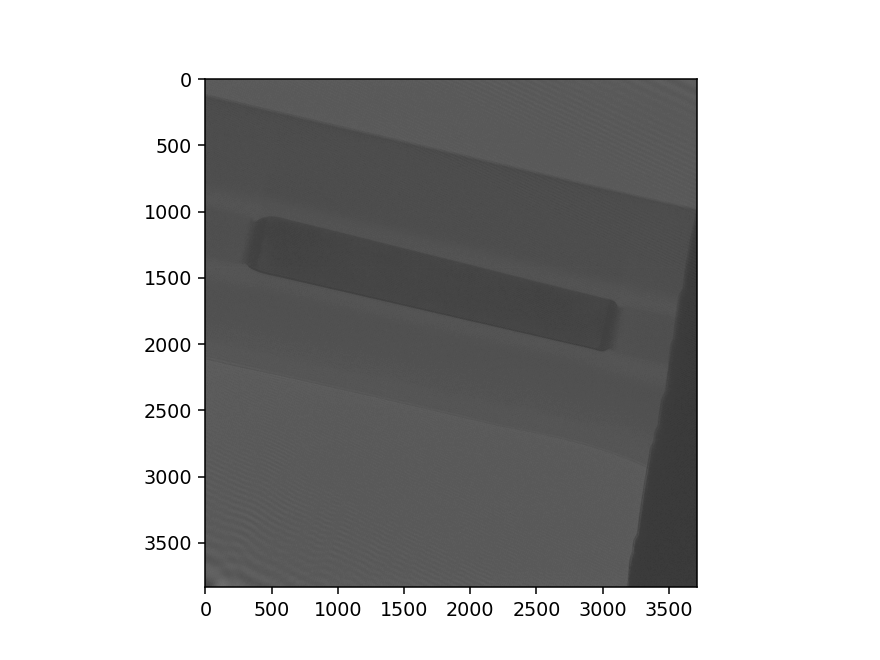

In [3]:
plt.figure()
plt.imshow(image_original, cmap="gray")

### Creating an Aperture
For the purpose of reconstruction, it is necessary to create an Aperture. The requirements to create an aperture are the position of the sideband and the size of the sideband.

#### Estimation of the sideband's position and size
In the liberTEM-Holo package, there are two functions to estimate the position and the size of the sideband.

In [5]:
sb_position = estimate_sideband_position(image_original,holo_sampling=(1,1)) #estimate the position of the sidebands
sb_size= estimate_sideband_size(sb_position,image_original.shape,sb_size_ratio=0.5) #estimate the size of the sidebands

#### Two function of creating an aperture
There are two function available in the Libertem-Holo Package to create an aperture. Both of the function will produce an aperture-array and value for slicing.

In [12]:
#Example to use the two option to create an Aperture

#Before using the get_aperture or get_aperture_gauss function, the size of the output need to be defined 
out_shape = (1024,1024)

#Example with get_aperture function
slice_fft1, aperture1 = get_aperture(out_shape=out_shape,sb_size=sb_size,sb_smoothness=15,sig_shape=image_original.shape)

#Example with get_aperture_gauss function
slice_fft2, aperture2 = get_aperture_gauss(out_shape=out_shape,sb_size=sb_size,sb_smoothness=15,sig_shape=image_original.shape)

<IPython.core.display.Javascript object>


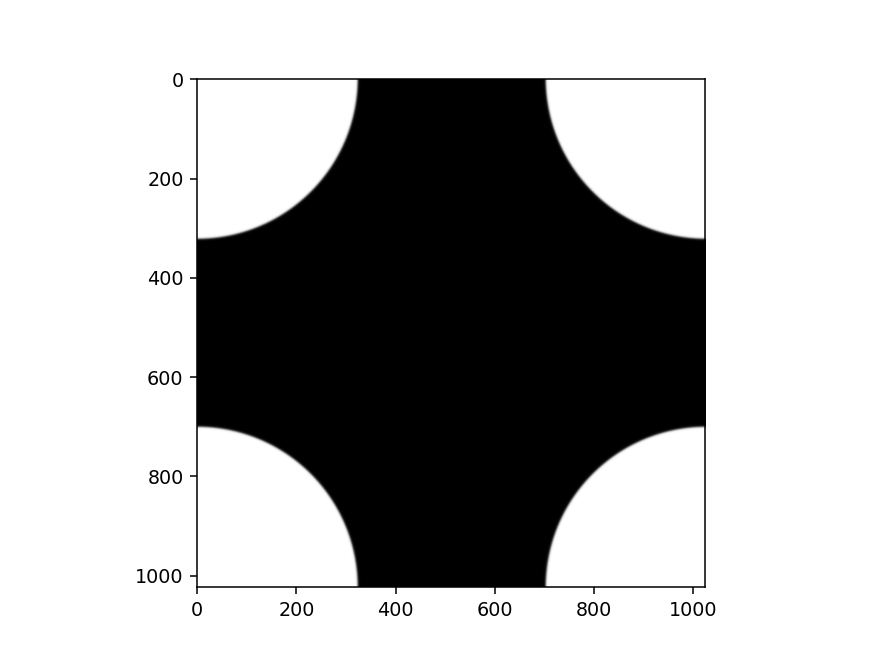

<IPython.core.display.Javascript object>


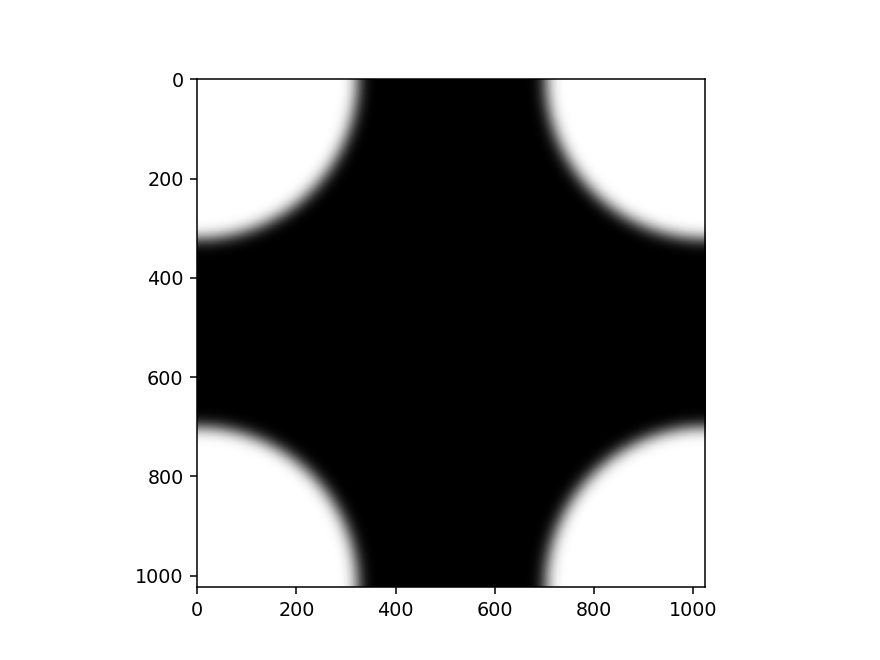

In [13]:
plt.figure()
plt.imshow(aperture1, cmap="gray")
plt.figure()
plt.imshow(aperture2, cmap="gray")

### Reconstruction
The reconstruction is done by using the reconstruct_frame function. The final reconstruction is done by unwrapping the phase based on the result array from reconstruct_frame function.

In [21]:
#reconstruction with the aperture and slice_fft based on get_aperture function
wav = reconstruct_frame(image_original, sb_pos=sb_position, slice_fft=slice_fft1, aperture=aperture1) 

<IPython.core.display.Javascript object>


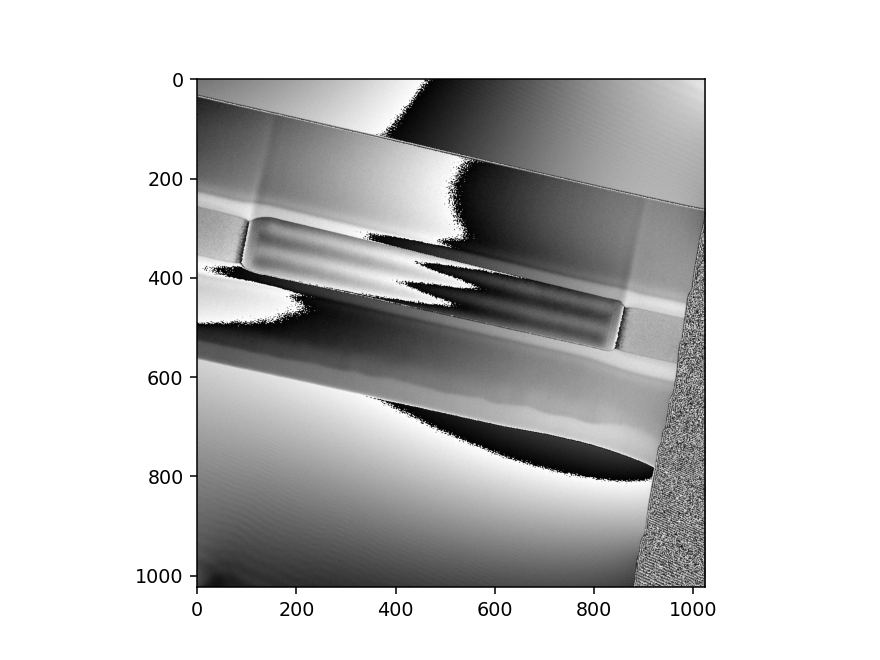

In [22]:
#wrapped phase
plt.figure()
plt.imshow(np.angle(wav), cmap="gray")

#### Unwrapping
The unwrapping is done by using skimage.restoration.unwrap_phase

<IPython.core.display.Javascript object>


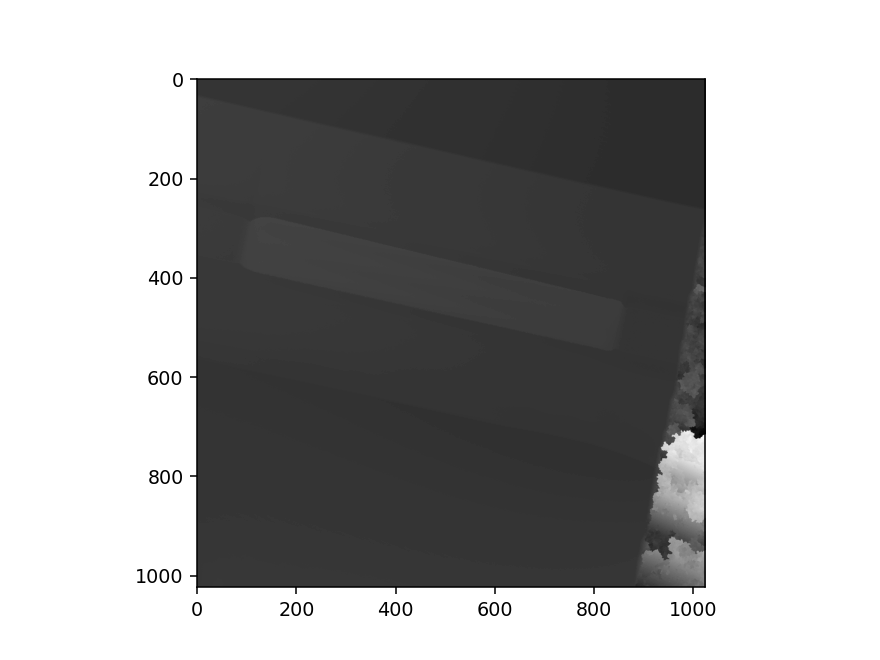

In [27]:
unwrap_phase_image = unwrap_phase(np.angle(wav))
plt.figure()
plt.imshow(np.max(unwrap_phase_image) - unwrap_phase_image, cmap="gray")